In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np

### Load the experiment and corresponding libraries

In [2]:
sys.path.append("/")  # enable import of "recipe"

In [3]:
from recipes.main import load_experiment
experiment = load_experiment(recipe="_2020_04_05_example", 
                             experiment="baseline", 
                             schema="",  # schema name will automatically be generated from recipe and experiment names 
                             base_dir="../", 
                             import_prefix="recipes.", 
                             dev_mode=True  # this installs and imports the current head of all repos 
                            )

Connecting anix@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


In [4]:
from bias_transfer.tables.trained_model import *
from bias_transfer.tables.trained_transfer_model import *
schema

Schema `anix_nnfabrik_2020_04_05_example`

#### Let's take a look at the individual experiments:

In [5]:
experiment.experiments.keys()

dict_keys([Description(name='Noise Augmented', seed=42), Description(name='Transfer', seed=42)])

#### ...and similarly for the combined transfer experiments:

In [6]:
experiment.transfer_experiments.keys()

dict_keys([Description(name='Noise Augmented -> Transfer', seed=42)])

#### How does the specific experiment definition look like? Let's look at an example instance:

In [7]:
from bias_transfer.configs.base import Description

In [8]:
experiment.experiments[Description(name='Transfer', seed=42)]

Experiment {
  "dataset": [
    "DatasetConfig",
    {
      "apply_augmentation": true,
      "apply_normalization": false,
      "batch_size": 128,
      "data_dir": "./data/image_classification/torchvision/",
      "dataset_cls": "CIFAR10",
      "description": "",
      "num_workers": 1,
      "pin_memory": true,
      "show_sample": false,
      "shuffle": true,
      "train_data_mean": [
        0.5070751592371323,
        0.48654887331495095,
        0.4409178433670343
      ],
      "train_data_std": [
        0.2673342858792401,
        0.2564384629170883,
        0.27615047132568404
      ],
      "valid_size": 0.1
    }
  ],
  "model": [
    "ModelConfig",
    {
      "description": "",
      "noise_adv_classification": false,
      "noise_adv_regression": false,
      "num_classes": 10,
      "type": 50
    }
  ],
  "seed": 42,
  "trainer": [
    "TrainerConfig",
    {
      "add_noise": false,
      "description": "Transfer + Reset",
      "force_cpu": false,
      "freeze

### Run experiments

In [9]:
from recipes.main import fill_tables, run_all_experiments

In [10]:
fill_tables(experiment.transfer_experiments)  



Noise Augmented
Transfer + Reset


In [11]:
run_all_experiments(experiment.transfer_experiments)

  0%|          | 0/1 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model with 23520842 parameters.
==> Building model..
==> Starting model Noise Augmented


Eval Epoch 0: 100%|██████████| 40/40 [00:02<00:00, 17.88it/s, acc=43.7, loss=1.49]

==> Saving..



Eval Epoch 1: 100%|██████████| 40/40 [00:02<00:00, 17.91it/s, acc=54.2, loss=1.27]

==> Saving..


==> Loading checkpoint..


Eval Epoch 1: 100%|██████████| 40/40 [00:02<00:00, 18.65it/s, acc=16.7, loss=2.79]

==> Loading checkpoint..



  0%|          | 0/1 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model with 23520842 parameters.
==> Building model..
==> Loading model..
==> Starting model Transfer + Reset


Eval Epoch 0: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s, acc=60, loss=1.1]   

==> Saving..



Eval Epoch 1: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, acc=61.3, loss=1.11]

==> Saving..


==> Loading checkpoint..


Eval Epoch 1: 100%|██████████| 40/40 [00:02<00:00, 18.17it/s, acc=12, loss=2.94]  

==> Loading checkpoint..



100%|██████████| 1/1 [01:33<00:00, 93.13s/it]
0it [00:00, ?it/s]


### In case something goes wrong:

In [28]:
# delete all jobs in error state:
if schema.database != "nnfabrik_core": 
    (schema.jobs & "status='error'").delete()

In [30]:
# drop the entire schema: THIS IS WILL DELETE EVERYTHING!
if schema.database != "nnfabrik_core": 
    schema.drop()

Proceed to delete entire schema `anix_nnfabrik_2020_04_05_example`? [yes, No]:  yes


### Analyse the results

In [28]:
from bias_transfer.analysis.analyzer import Analyzer
import seaborn as sns

In [24]:
analysis = Analyzer()

In [25]:
analysis.add_data(experiment.experiments, TrainedModel(), transfer_level=0)
analysis.df

,name,comment,training_progress,test_acc,test_loss,dev_acc,epoch,dev_noise_acc,dev_noise_loss
0,Noise Augmented,Noise Augmented..,"[{'train_acc': 35.64666666666667, 'train_loss'...",56.26,1.213806,54.22,1,"{'noise_snr': {'5.0_1.0': 56.28, '4.0_1.0': 56...","{'noise_snr': {'5.0_1.0': 1.2234528362751007, ..."


In [26]:
analysis.add_data(experiment.transfer_experiments, TrainedTransferModel(), transfer_level=1)
analysis.df

,name,comment,training_progress,test_acc,test_loss,dev_acc,epoch,dev_noise_acc,dev_noise_loss
0,Noise Augmented,Noise Augmented..,"[{'train_acc': 35.64666666666667, 'train_loss'...",56.26,1.213806,54.22,1,"{'noise_snr': {'5.0_1.0': 56.28, '4.0_1.0': 56...","{'noise_snr': {'5.0_1.0': 1.2234528362751007, ..."
0,Noise Augmented -> Transfer,Transfer + Reset..,"[{'train_acc': 56.01777777777778, 'train_loss'...",61.22,1.105052,61.30,1,"{'noise_snr': {'5.0_1.0': 60.26, '4.0_1.0': 59...","{'noise_snr': {'5.0_1.0': 1.1151368781924247, ..."


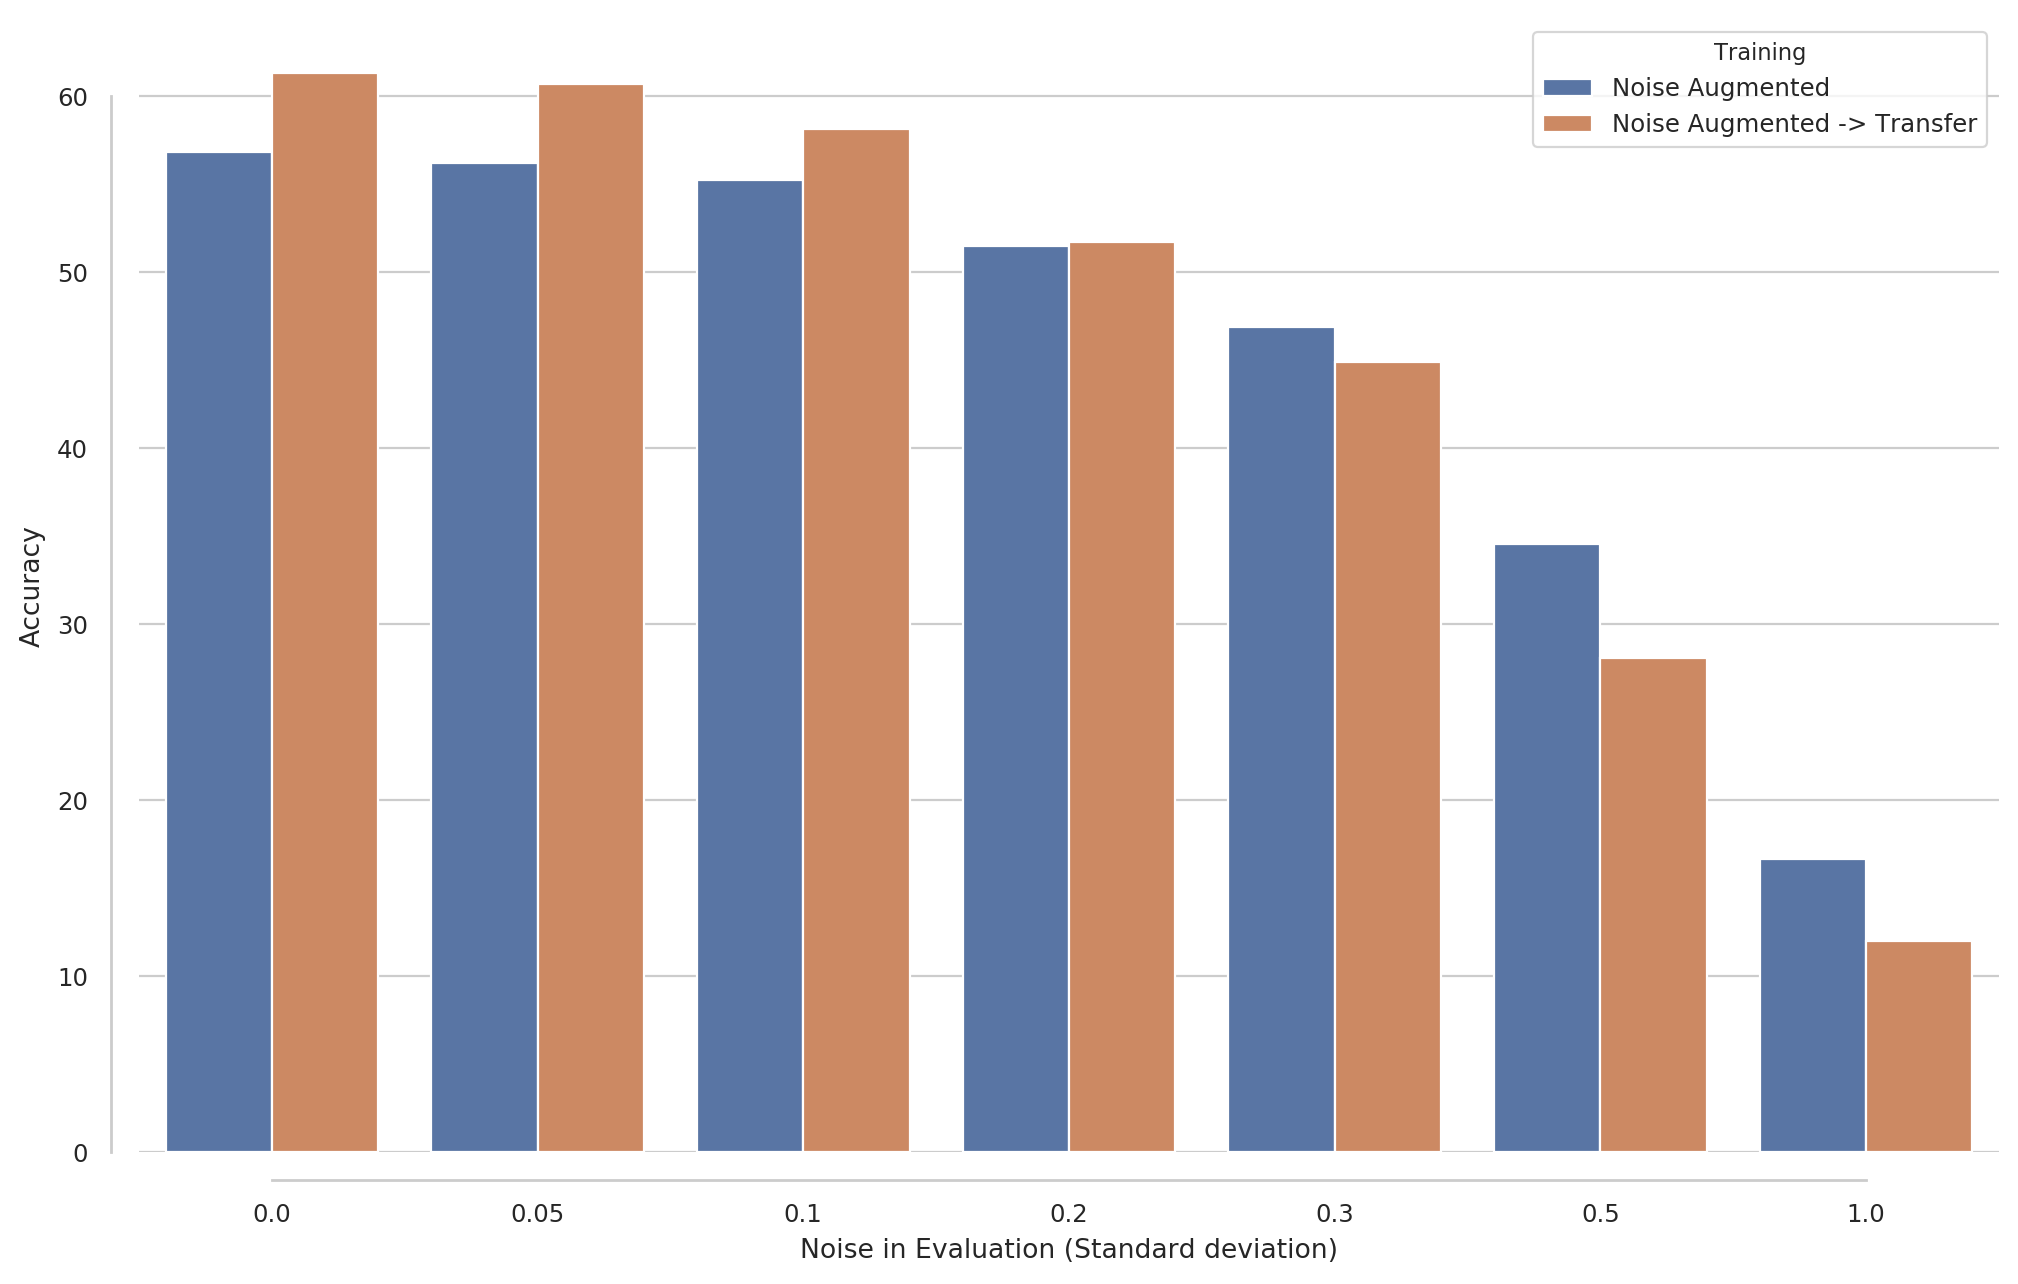

In [29]:
x = analysis.plot(to_plot="dev_noise_acc", 
       noise_measure="std",
       kind=None, 
       plot_method=sns.barplot,
        save="rep_matching",
        style="lightpaper"
       )